In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [137]:
from sklearn.preprocessing import OrdinalEncoder,  OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Loading data

In [138]:
url= "https://raw.githubusercontent.com/nithinpradeep38/datasets/main/Train.csv"

In [139]:
data= pd.read_csv(url)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [140]:
data.shape

(8523, 12)

We have 12 variables. 11 independent variables and 1 dependent variable (Item Outlet sales).

In [141]:
for col in data.columns:
    print(f"{col}: {data[col].dtype}")

Item_Identifier: object
Item_Weight: float64
Item_Fat_Content: object
Item_Visibility: float64
Item_Type: object
Item_MRP: float64
Outlet_Identifier: object
Outlet_Establishment_Year: int64
Outlet_Size: object
Outlet_Location_Type: object
Outlet_Type: object
Item_Outlet_Sales: float64


We have 11 independent variables out of which 4 are numerical columns and 7 are categorical columns. The output variable is a numerical column which makes this a **regression problem.**

In [142]:
#Let us separate the categorial columns.
cat_col= [col for col in data.columns if data[col].dtype== 'object']
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [143]:
num_col= [col for col in data.columns if data[col].dtype!= 'object']
num_col

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [144]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We see 1463 values missing in Item_weight column and 2410 values missing in Outlet_size column.

#### Unique values for the categorical columns

In [145]:
for col in cat_col:
    print(f"{col}: {data[col].nunique()}")

Item_Identifier: 1559
Item_Fat_Content: 5
Item_Type: 16
Outlet_Identifier: 10
Outlet_Size: 3
Outlet_Location_Type: 3
Outlet_Type: 4


## Checking distributions

### Item Weight

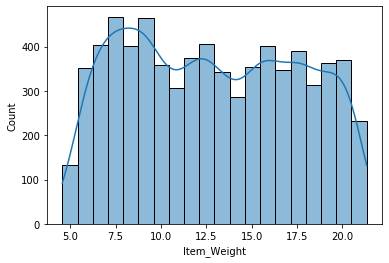

In [146]:
sns.histplot(data['Item_Weight'], kde= True, bins= 20)
plt.show()

In [147]:
np.round(data['Item_Weight'].mean(),2)

12.86

The mean weight of items is 12.86 and the weights range between 5 to 20 kgs.

### Item visibility

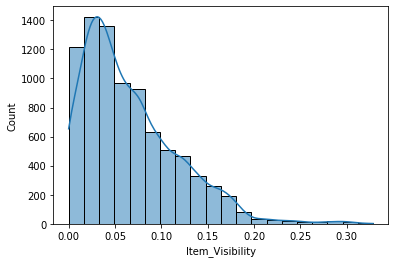

In [148]:
sns.histplot(data['Item_Visibility'], kde= True, bins= 20)
plt.show()

Most items have low visibility followed by outliers with high visibility. It is a positively skewed distribution.

### Item MRP

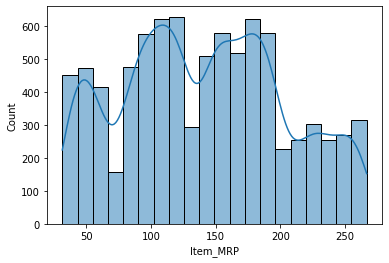

Range of MRP is (31.29, 266.8884)


In [149]:
sns.histplot(data['Item_MRP'], kde= True, bins= 20)
plt.show()
print(f"Range of MRP is ({data['Item_MRP'].min()}, {data['Item_MRP'].max()})")

Prices are clustered at around 50, 100 and 175

### Outlet establishment year


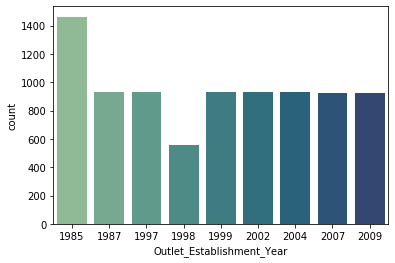

In [150]:
sns.countplot(x= 'Outlet_Establishment_Year',data= data, palette= 'crest')
plt.show()

The most number of outlets were opened up in 1985 (~1400). In 1998 there was a big dip. The rest of the years had same or similar number of outlets established.

### Item fat content

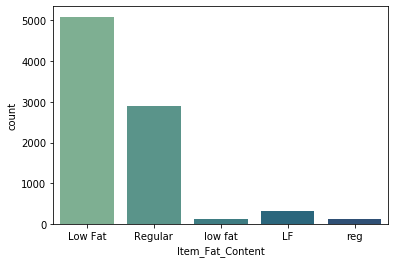

In [151]:
sns.countplot(x='Item_Fat_Content', data= data , palette='crest')
plt.show()

Majority of the data points have either **Low fat** or **Regular** as the Item_fat_content. 

**low fat** and **LF** may just be **Low fat**. To reduce cardinality, we can map these to Low fat category.
Similarly, **reg** can be renamed as **Regular**.

### Item Type

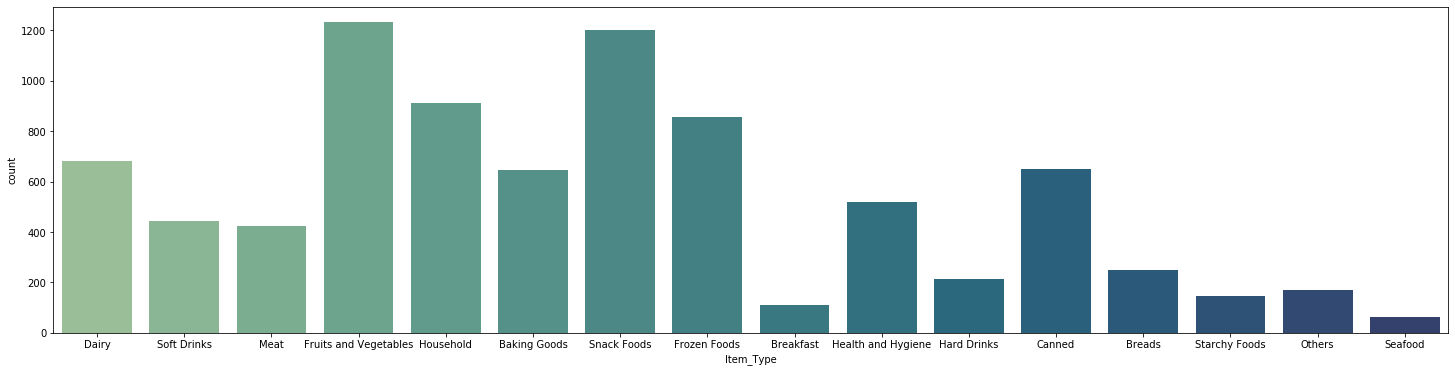

In [152]:
plt.figure(figsize= (25,6))
sns.countplot(x='Item_Type', data= data , palette='crest')
plt.show()

There are 16 levels for this variable and some of them like breakfast and seafood appear to be rare variables. This high cardinality can be an issue, especially in tree based algorithms. Rare labels in training set can cause overfitting. If such labels are only present in test set, the algorithm may not know what do with them. So we may have to group these labels.

### Outlet size

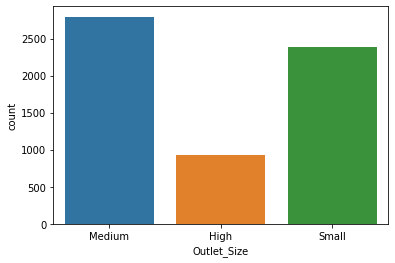

In [153]:
sns.countplot(x='Outlet_Size', data=data)
plt.show()

### Outlet Location type

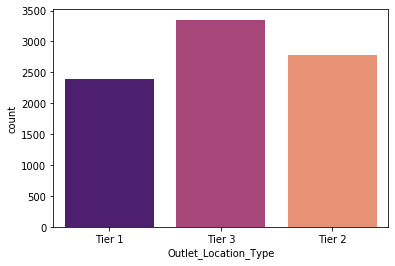

In [154]:
sns.countplot(x='Outlet_Location_Type', data=data, palette= 'magma')
plt.show()

### Outlet Type

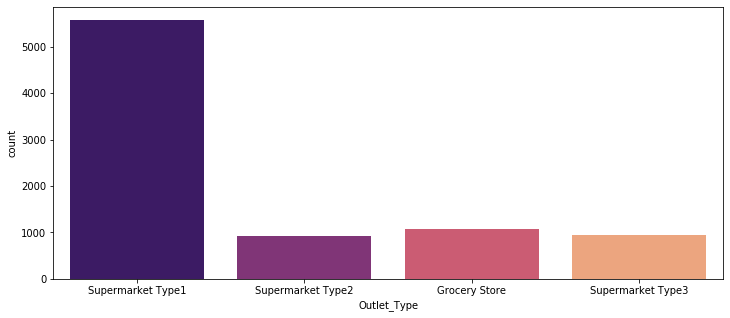

In [155]:
plt.figure(figsize= (12,5))
sns.countplot(x='Outlet_Type', data=data, palette= 'magma')
plt.show()

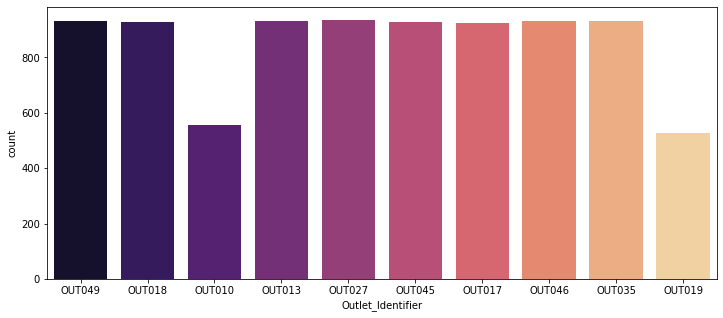

In [156]:
plt.figure(figsize= (12,5))
sns.countplot(x='Outlet_Identifier', data=data, palette= 'magma')
plt.show()

### Data Processing- Reducing cardinality

The item_identifier column has 1559 unique values. Such high cardinality is undesirable. So we will try to transform this column to have a lower cardinality. Let us first inspect this.

#### Treating high cardinality and fixing duplicate labels

In [157]:
data['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

The first two digits maybe indicative of a sub-category. Let us inspect the same.

In [158]:
first_two= set(data['Item_Identifier'].str[:2])
first_two

{'DR', 'FD', 'NC'}

The first two digits of item identifier are either of DR, FD or NC. Let us inspect the sub-set of data individually for these.

In [159]:
data[data['Item_Identifier'].str[:2]=='DR']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
27,DRJ59,11.650,low fat,0.019356,Hard Drinks,39.1164,OUT013,1987,High,Tier 3,Supermarket Type1,308.9312
34,DRH01,17.500,Low Fat,0.097904,Soft Drinks,174.8738,OUT046,1997,Small,Tier 1,Supermarket Type1,2085.2856
37,DRZ11,8.850,Regular,0.113124,Soft Drinks,122.5388,OUT018,2009,Medium,Tier 3,Supermarket Type2,1609.9044
...,...,...,...,...,...,...,...,...,...,...,...,...
8484,DRJ49,6.865,Low Fat,0.000000,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8506,DRF37,17.250,Low Fat,0.084676,Soft Drinks,263.1910,OUT018,2009,Medium,Tier 3,Supermarket Type2,3944.8650


In [160]:
data[data['Item_Identifier'].str[:2]=='FD']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
...,...,...,...,...,...,...,...,...,...,...,...,...
8515,FDH24,20.700,Low Fat,0.021518,Baking Goods,157.5288,OUT018,2009,Medium,Tier 3,Supermarket Type2,1571.2880
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850


In [161]:
data[data['Item_Identifier'].str[:2]=='NC']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
16,NCB42,11.80,Low Fat,0.008596,Health and Hygiene,115.3492,OUT018,2009,Medium,Tier 3,Supermarket Type2,1621.8888
22,NCB30,14.60,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
25,NCD06,13.00,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
31,NCS17,18.60,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009,Medium,Tier 3,Supermarket Type2,2741.7644
...,...,...,...,...,...,...,...,...,...,...,...,...
8500,NCQ42,20.35,Low Fat,0.000000,Household,125.1678,OUT017,2007,NaN,Tier 2,Supermarket Type1,1907.5170
8502,NCH43,8.42,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8516,NCJ19,18.60,Low Fat,0.118661,Others,58.7588,OUT018,2009,Medium,Tier 3,Supermarket Type2,858.8820


It is clear from the sub-sets of data that 'DR' represents items that are 'drinks', 'FD' represents items that are 'food' and 'NC' represents items that are 'non consumables'.

So as a data pre-processing step, we can map this column to represent these three categories thereby reducing cardinality of this column.

In [162]:
data['Item_Identifier']= data['Item_Identifier'].apply(lambda x:x[0:2]).map({'FD': "Food", 'DR': 'Drinks', 'NC': 'Non Consumable'})

In [163]:
data['Item_Fat_Content']= data['Item_Fat_Content'].map({'Low Fat': 'Low Fat', 'Regular': 'Regular', 'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

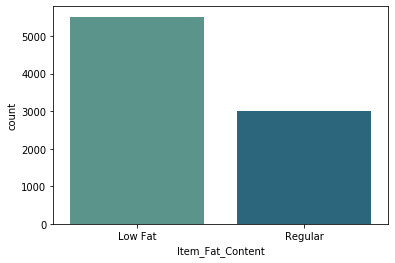

In [164]:
sns.countplot(x='Item_Fat_Content', data= data , palette='crest')
plt.show()


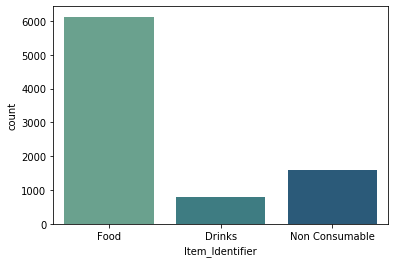

In [165]:
sns.countplot(x='Item_Identifier', data= data , palette='crest')
plt.show()

We have solved the cardinality issues in Item_Fat_Content and Item_Identifier columns. Now let us look at item type.

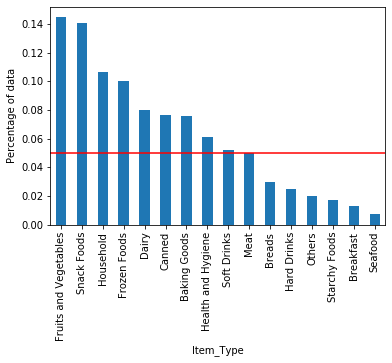

In [166]:
def rare_label_plot(data, col):
    temp_df = pd.Series(data[col].value_counts() / len(data))

    # Make plot with these percentages.
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # Add a line at 5 % to flag the threshold for rare categories.
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of data')
    plt.show()
    
rare_label_plot(data, 'Item_Type')

In [167]:
temp_df

,Item_Type,% of data,Item_Outlet_Sales
0,Fruits and Vegetables,0.144550,2289.009592
1,Snack Foods,0.140795,2277.321739
2,Household,0.106770,2258.784300
3,Frozen Foods,0.100434,2132.867744
4,Dairy,0.080019,2232.542597
5,Canned,0.076147,2225.194904
6,Baking Goods,0.076030,1952.971207
7,Health and Hygiene,0.061011,2010.000265
8,Soft Drinks,0.052212,2006.511735
9,Meat,0.049865,2158.977911


Let us plot the mean of target variable across the different rare labels.



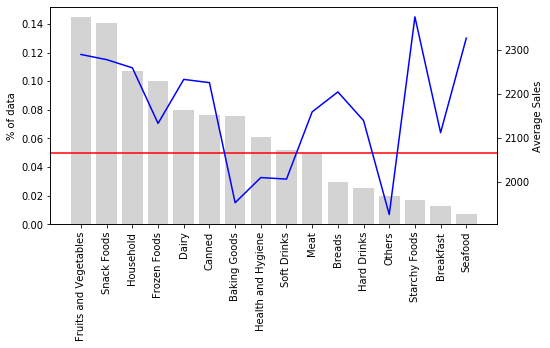

In [168]:
def plot_mean(data, col):
    l= len(data)

    temp_df= pd.Series(data[col].value_counts()/l).reset_index()
    temp_df.columns= [col, '% of data']
    temp_df= temp_df.merge(data.groupby([col])['Item_Outlet_Sales'].mean().reset_index(), on=col, how= 'left')

    temp_df

    fig, ax= plt.subplots(figsize= (8,4))
    plt.xticks(temp_df.index, temp_df[col], rotation= 90)
    ax2= ax.twinx()
    ax.bar(temp_df.index, temp_df['% of data'], color= 'lightgrey')
    ax2.plot(temp_df.index, temp_df['Item_Outlet_Sales'],color= 'blue')
    ax.axhline(y=0.05, color= 'red')
    ax.set_ylabel('% of data')
    ax2.set_ylabel('Average Sales')
    plt.show()
    
plot_mean(data, 'Item_Type')


For the labels that are in more than 5% of the dataset, we do see a negative trend of sales price. So these labels maybe meaningful.

There is a lot of variance across the rare labels. Let us plot the box plots for these variables.


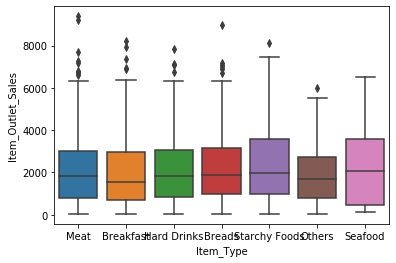

In [169]:
rare_labels= list(temp_df[temp_df['% of data']< 0.05]['Item_Type'])
rare_labels

sns.boxplot(x= 'Item_Type', y= 'Item_Outlet_Sales', data= data[data['Item_Type'].isin(rare_labels)])


In [170]:
rare_labels

['Meat',
 'Breads',
 'Hard Drinks',
 'Others',
 'Starchy Foods',
 'Breakfast',
 'Seafood']

In [171]:
fvalue, pvalue = stats.f_oneway(data[data['Item_Type']== 'Meat']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Breads']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Hard Drinks']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Seafood']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Starchy Foods']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Breakfast']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Others']['Item_Outlet_Sales']
                               )



pvalue

0.3573271647648517

We can combine the rare labels into one category and plot the mean again.

In [172]:
data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [173]:
grouping_dict = {
        k: ('rare' if k in rare_labels else k)
        for k in data['Item_Type'].unique()
        
    }
grouping_dict

{'Dairy': 'Dairy',
 'Soft Drinks': 'Soft Drinks',
 'Meat': 'rare',
 'Fruits and Vegetables': 'Fruits and Vegetables',
 'Household': 'Household',
 'Baking Goods': 'Baking Goods',
 'Snack Foods': 'Snack Foods',
 'Frozen Foods': 'Frozen Foods',
 'Breakfast': 'rare',
 'Health and Hygiene': 'Health and Hygiene',
 'Hard Drinks': 'rare',
 'Canned': 'Canned',
 'Breads': 'rare',
 'Starchy Foods': 'rare',
 'Others': 'rare',
 'Seafood': 'rare'}

In [174]:
data['Item_Type']= data['Item_Type'].map(grouping_dict)



In [175]:
data['Item_Type'].unique()
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Food,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,Drinks,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,Food,17.500,Low Fat,0.016760,rare,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,Food,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,Non Consumable,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,Food,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,Food,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,Non Consumable,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,Food,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


With this, we have treated the cardinality and fixed some duplicates in Item_Fat_Content, Item_Identifier and Item_Type. Let us look at the unique values in each column now.

In [208]:
data[cat_col].nunique()

Item_Identifier          3
Item_Fat_Content         2
Item_Type               10
Outlet_Identifier       10
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

### Imputation

In [177]:
num_col.remove('Item_Outlet_Sales')
num_col

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [178]:
numerical_imputer= SimpleImputer(strategy= 'median')
categorical_imputer= SimpleImputer(strategy= 'most_frequent')

In [179]:
data[num_col]= numerical_imputer.fit_transform(data[num_col])
data[cat_col]= categorical_imputer.fit_transform(data[cat_col])

In [180]:
data.isna().sum() #imputation performed successfully

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [181]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Food,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380
1,Drinks,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228
2,Food,17.500,Low Fat,0.016760,rare,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700
3,Food,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998.0,Medium,Tier 3,Grocery Store,732.3800
4,Non Consumable,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,Food,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987.0,High,Tier 3,Supermarket Type1,2778.3834
8519,Food,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002.0,Medium,Tier 2,Supermarket Type1,549.2850
8520,Non Consumable,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004.0,Small,Tier 2,Supermarket Type1,1193.1136
8521,Food,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,1845.5976


### Plotting relationship with target variable

In [182]:
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

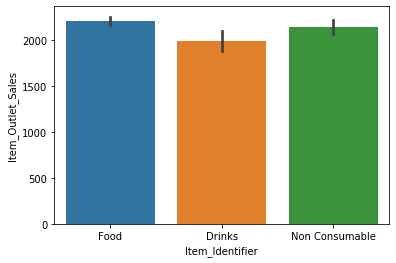

In [183]:
#The average sales across different item types is quite even

sns.barplot(x='Item_Identifier', y='Item_Outlet_Sales', data=data)
plt.show()

In [209]:
fvalue, pvalue = stats.f_oneway(data[data['Item_Identifier']== 'Food']['Item_Outlet_Sales'],
                                data[data['Item_Identifier']== 'Drinks']['Item_Outlet_Sales'],
                                data[data['Item_Identifier']== 'Non Consumable']['Item_Outlet_Sales']
                                
                               )



pvalue
#This column may be meaningful in prediction.

0.0018844050713309338

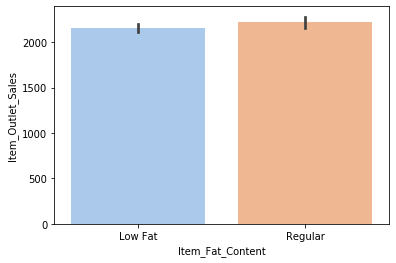

In [184]:
sns.barplot(x = 'Item_Fat_Content',y = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

In [212]:
fvalue, pvalue = stats.f_oneway(data[data['Item_Fat_Content']== 'Low Fat']['Item_Outlet_Sales'],
                                data[data['Item_Fat_Content']== 'Regular']['Item_Outlet_Sales'],
                                
                                
                               )
pvalue
#Difficult to say if the feature is significant. Let us retain it for the time being.

0.08398916967694944

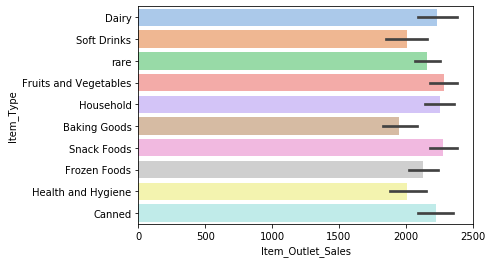

In [185]:
sns.barplot(y = 'Item_Type',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

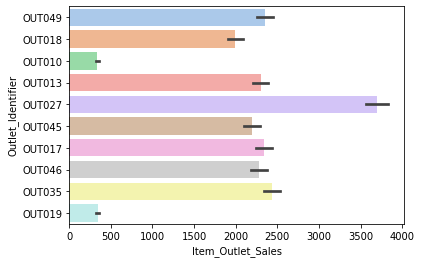

In [186]:
sns.barplot(y = 'Outlet_Identifier',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

Let us dig deep into outlet identifier.

Some of the labels can be clubbed together as they have same distribution across the target variable. Let us confirm the hypothesis through one-way ANOVA

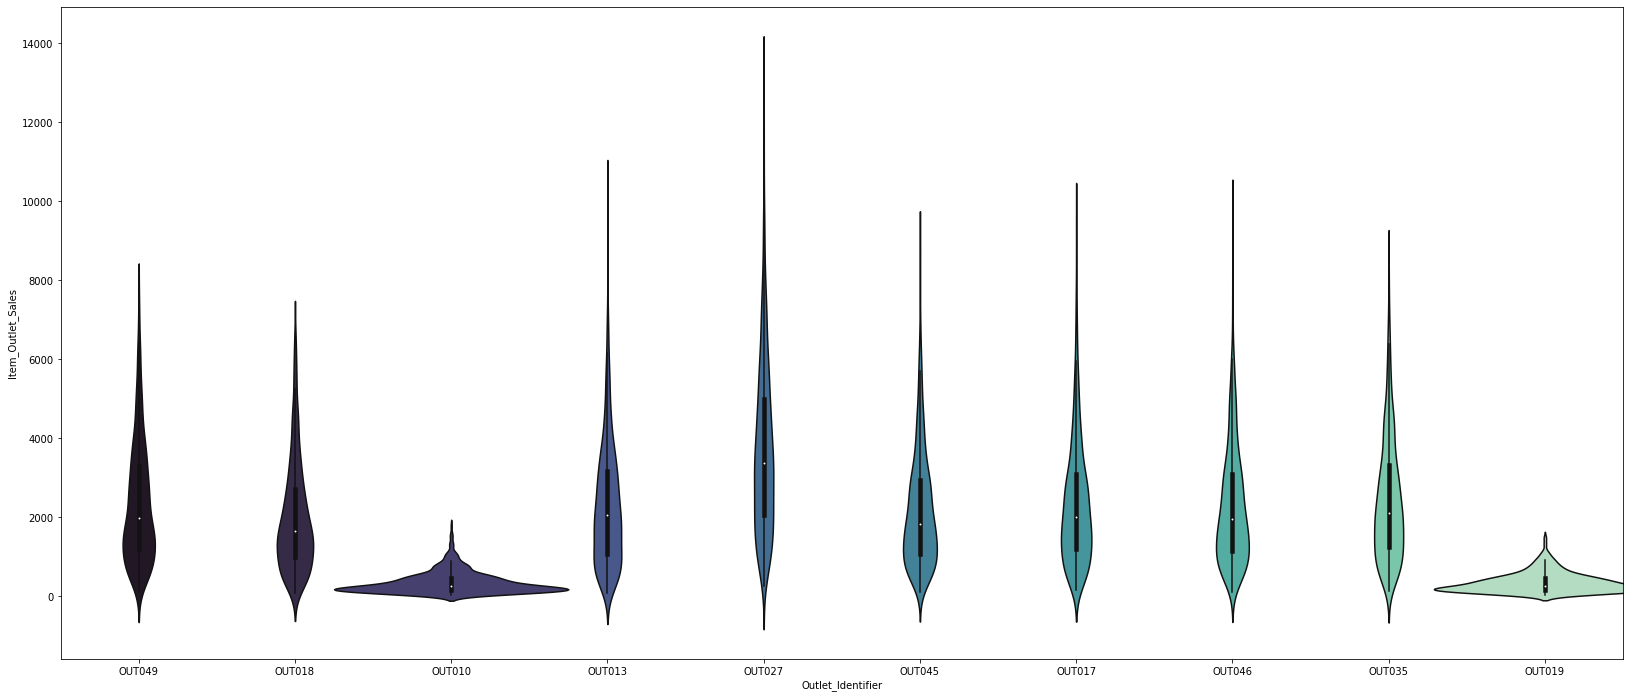

In [217]:
plt.figure(figsize= (28,12))
sns.violinplot(x= 'Outlet_Identifier', y= 'Item_Outlet_Sales', width= 1.5, data= data, palette= 'mako')

In [219]:
import itertools
identifier= data['Outlet_Identifier'].unique()
combo= list(itertools.combinations(identifier, 2))
for i in combo:
    fvalue, pvalue = stats.f_oneway(data[data['Outlet_Identifier']== i[0]]['Item_Outlet_Sales'],data[data['Outlet_Identifier']== i[1]]['Item_Outlet_Sales'])
    print(f"p-value of {i[0]} and {i[1]} is {pvalue}")

p-value of OUT049 and OUT018 is 1.6237610660043112e-07
p-value of OUT049 and OUT010 is 6.83969470305172e-163
p-value of OUT049 and OUT013 is 0.4846168437306292
p-value of OUT049 and OUT027 is 1.877987516159982e-52
p-value of OUT049 and OUT045 is 0.023963611637588412
p-value of OUT049 and OUT017 is 0.9140329144118972
p-value of OUT049 and OUT046 is 0.3111714413542868
p-value of OUT049 and OUT035 is 0.20115834440551564
p-value of OUT049 and OUT019 is 2.1272163678298524e-156
p-value of OUT018 and OUT010 is 4.800336496067525e-139
p-value of OUT018 and OUT013 is 7.500690453772567e-06
p-value of OUT018 and OUT027 is 5.856140005447328e-84
p-value of OUT018 and OUT045 is 0.002846968971197406
p-value of OUT018 and OUT017 is 4.385309432249914e-07
p-value of OUT018 and OUT046 is 2.28906391365231e-05
p-value of OUT018 and OUT035 is 7.603052607618273e-11
p-value of OUT018 and OUT019 is 1.8122293078826514e-133
p-value of OUT010 and OUT013 is 1.4901491481022403e-153
p-value of OUT010 and OUT027 is 1.

In [220]:
fvalue, pvalue = stats.f_oneway(data[data['Outlet_Identifier']== 'OUT017']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT049']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT013']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT046']['Item_Outlet_Sales'],
                                
                               )



pvalue

0.7138206624905409

In [221]:
fvalue, pvalue = stats.f_oneway(data[data['Outlet_Identifier']== 'OUT010']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT019']['Item_Outlet_Sales'],
                               
            
                               )

pvalue

0.9508542567870439

This confirms that there is no statistically significant difference in the target variable distribution between OUT017, OUT049, OUT013, OUT046 identifiers. So they can be combined to one label.

Similarly, OUT010 and OUT019 can be combined to one label.

In [228]:
grouping_dict = {
        k: ('Cluster0' if k in ['OUT017', 'OUT049', 'OUT013', 'OUT046']
            else k)
        for k in data['Outlet_Identifier'].unique()
        
    }
grouping_dict['OUT010']= 'Cluster1'
grouping_dict['OUT019']= 'Cluster1'
grouping_dict

{'OUT049': 'Cluster0',
 'OUT018': 'OUT018',
 'OUT010': 'Cluster1',
 'OUT013': 'Cluster0',
 'OUT027': 'OUT027',
 'OUT045': 'OUT045',
 'OUT017': 'Cluster0',
 'OUT046': 'Cluster0',
 'OUT035': 'OUT035',
 'OUT019': 'Cluster1'}

In [229]:
data['Outlet_Identifier']= data['Outlet_Identifier'].map(grouping_dict)
data['Outlet_Identifier'].unique()

array(['Cluster0', 'OUT018', 'Cluster1', 'OUT027', 'OUT045', 'OUT035'],
      dtype=object)

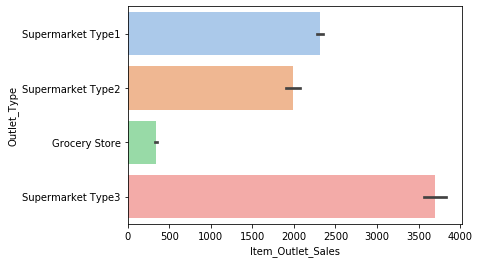

In [187]:
sns.barplot(y = 'Outlet_Type',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

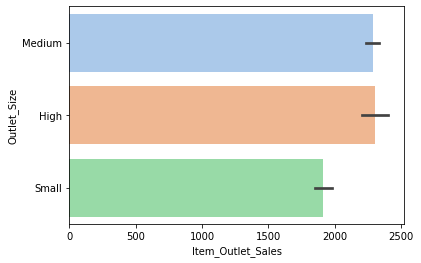

In [188]:
sns.barplot(y = 'Outlet_Size',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

In [189]:
#The high and medium outlets have relatively higher avg sales than small outlets. 
#So maybe there is an ordinal relationship between labels.
data.groupby('Outlet_Size')['Item_Outlet_Sales'].mean()

Outlet_Size
High      2298.995256
Medium    2283.730470
Small     1912.149161
Name: Item_Outlet_Sales, dtype: float64

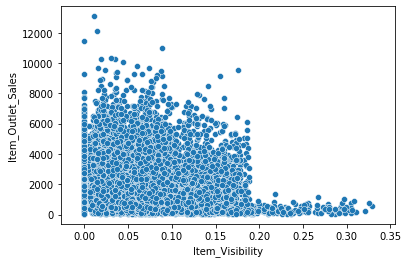

In [190]:
sns.scatterplot(x = 'Item_Visibility',y = 'Item_Outlet_Sales',data=data)
plt.show()

Till a visibility level of 0.2, the sales are not affected strongly by visibility. Beyond a visibility of 0.2, the sales are quite low.

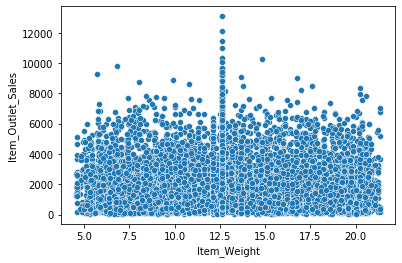

In [191]:
sns.scatterplot(x = 'Item_Weight',y = 'Item_Outlet_Sales',data=data)
plt.show()

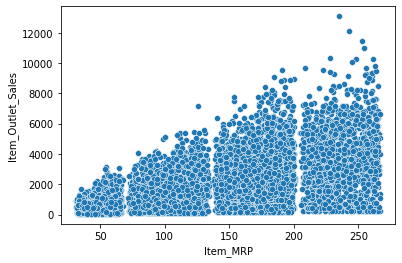

In [192]:
sns.scatterplot(x = 'Item_MRP',y = 'Item_Outlet_Sales',data=data)
plt.show()

In [193]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureGenerator(BaseEstimator, TransformerMixin):


    def __init__(self,  Outlet_Establishment_Year_id= 3):
        self.Outlet_Establishment_Year_id= Outlet_Establishment_Year_id
        
    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y= None):
            X[:,self.Outlet_Establishment_Year_id]= 2022- X[:,self.Outlet_Establishment_Year_id]
                
            return X

In [194]:
data['Outlet_Establishment_Year']= 2022-data['Outlet_Establishment_Year']

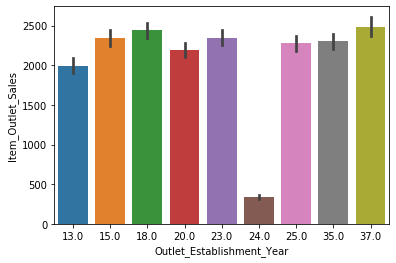

In [195]:
#Sales are 
sns.barplot(x = 'Outlet_Establishment_Year',y = 'Item_Outlet_Sales',data=data)
plt.show()

In [196]:
data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().sort_values(ascending= False)

Outlet_Establishment_Year
37.0    2483.677474
18.0    2438.841866
23.0    2348.354635
15.0    2340.675263
35.0    2298.995256
25.0    2277.844267
20.0    2192.384798
13.0    1995.498739
24.0     339.351662
Name: Item_Outlet_Sales, dtype: float64